## Part 1: Capacitance of a Capacitor

Importing Libraries

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.ascii as ascii
from scipy.optimize import curve_fit
%matplotlib inline

Reading in data

In [123]:
data = ascii.read('RCdata_7.dat')
print(data.colnames)

['t', 'V', 'e_V']


In [124]:
#Making sure everything is in same units
t = data['t']
V = data['V'] / 1000.0
error_V = data['e_V'] / 1000000.0

#Resistance
R = 5010
error_R = 30

#Supply_V is the initial Voltage
supply_V = V[0]
error_supply_V = error_V[0]

print(supply_V, error_supply_V)

0.242959 0.0038907867


Least Squared Function

In [125]:
#Function to perform the weighted least squared fit
#Inputs: the x data, y data and the uncertainty
#Outputs: the fitted gradient and y-intercept

def least_square(x, y, sigma):

    #Calculating the different sums:
    Sx = sum( x / sigma**2 )
    Sy = sum( y / sigma**2 )
    Sxy = sum( x * y /sigma**2 )
    Sxx = sum( x * x / sigma**2 )
    N = x.size
    S =sum( (x*0.+1.) / (sigma * sigma) )

    #Optimising m and c:
    fit_m = ( (S * Sxy) - (Sx * Sy) ) / ( (S * Sxx) - (Sx * Sx) )
    fit_c = ( (Sxx * Sy) - (Sx * Sxy) )/( ( S * Sxx) - (Sx * Sx) )

    return(fit_m , fit_c)

Fitting to Least Squared

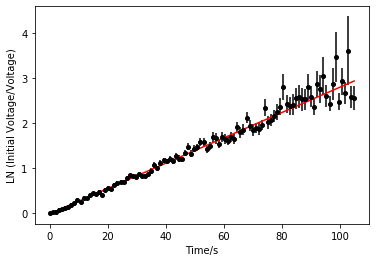

In [132]:
#Taking the log to give a linear fit
y = np.log( supply_V / V) 
#Propagating the errors
error_y = np.sqrt ( ( ( (1 / supply_V)**2 ) * (error_supply_V**2) ) + ( ( (1 / V)**2 ) * (error_V**2) ))

#Plotting
plt.errorbar(t , y , yerr=error_y , fmt='ko',markersize=4)
plt.xlabel("Time/s")
plt.ylabel("LN (Initial Voltage/Voltage)")

#Applying Least square function
LS_m, LS_c = least_square(t, y, error_y)

#Plotting the least squared model
LS_fit_y = LS_m * t + LS_c
plt.plot(t, LS_fit_y, 'r')


In [133]:
#Printing the fitted gradient and y-intercept
print(LS_m, LS_c)

LS_C = 1 / ( LS_m * R )

#Printing Capacitance:
print(LS_C)

0.028139504537376403 -0.019948038205470055
0.007093259163041521


Bootstrap Function

In [134]:
#Function to perform a bootstrap fit
#Inputs: x data, y data, the fitted data, errors, and the number of iterations for the bootstrap
#Outputs: array that contains all of the fitted gradients and y-intercepts

def bootstrap(x, y, fit_y, errors_y, num_iteration):
    
    #Array for stored values
    store = np.zeros((2, num_iteration))   
    
    #Loop to get bootstap values over number of iterations inputted
    for i in range(num_iteration):

        #getting residuals
        residual = y - fit_y
        #getting size of array
        size = len(residual)
            
        #getting a array with a random numbers    
        randnums= np.random.randint(1 , size , size)

        #reorganising the residual and error arrays
        residual = residual[randnums]
        errors_y = errors_y[randnums]
        
        #generating the new array by adding the best fit data
        new_y = residual + fit_y

        #performing least square fit and storing m,c in stored values
        store[0][i], store[1][i] = least_square ( x, new_y, errors_y )

    return(store)

Applying bootstrap to data

In [135]:
BS = bootstrap(t, y, LS_fit_y, error_y, 100000)
#getting data out of stored array
BS_m = BS[0,:]
BS_c = BS[1,:]

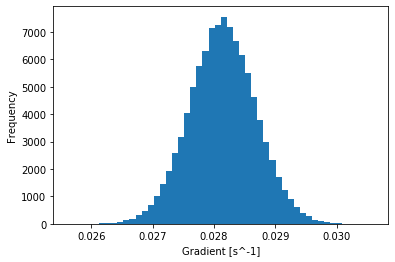

In [143]:
plt.hist(BS_m, bins=50)
plt.xlabel('Gradient [s^-1]')
plt.ylabel('Frequency')
plt.show()

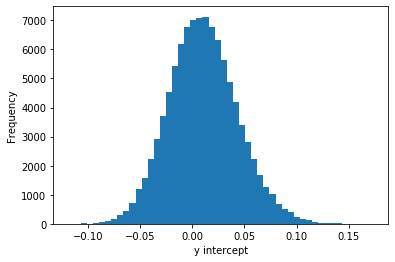

In [142]:
plt.hist(BS_c, bins=50)
plt.ylabel('Frequency')
plt.xlabel('y intercept')
plt.show()

Function to get the 16-84% accuracy:

In [138]:
#Inputs: an array to get the uncertainty from
#Outputs: lower uncertainty, higher uncertainty, median value

def error(m):
    #sorting from lowest to highest
    sort = np.sort(m)    

    low_percent = int(m.size*16/100)
    high_percent = int(m.size*84/100)
    halfway = int(m.size*1/2)

    #getting uncertainty from the difference between 16% and 50% through sorted array
    l_unc = sort[halfway] - sort[low_percent]
    h_unc = sort[high_percent] - sort[halfway]
    median =  sort[halfway]
    
    return l_unc, h_unc, median

Working out errors:

In [139]:
#mean and standard deviation equations:
mean_BS_m = np.mean(BS_m)
std_BS_m = np.std(BS_m)
mean_BS_c = np.mean(BS_c)
std_BS_c = np.std(BS_c)

low_m, high_m, median_m = error(BS_m)
low_c, high_c, median_c = error(BS_c)

print("Average gradient = %g\nStandard deviation = %g\nHigh error = %g, Low error = %g\n Median = %g\n" % (mean_BS_m, std_BS_m, high_m, low_m, median_m))

print("Average intercept = %g\nStandard deviation = %g\nHigh error = %g, Low error = %g\nMedian = %g\n" % (mean_BS_c, std_BS_c, high_c, low_c, median_c))

Average gradient = 0.0281394
Standard deviation = 0.000541176
High error = 0.000535143, Low error = 0.000530352
 Median = 0.0281384

Average intercept = 0.0105409
Standard deviation = 0.0327642
High error = 0.0333547, Low error = 0.0313507
Median = 0.00947803



Working out a reduced chi squared:

In [147]:
m1 = 0.0281384
c1 = 0.009478033

#funct to return the model from the parameters
def fit_func(x, m, c):
    return x * m + c

print (np.sum((y - fit_func(t, m1, c1))**2/(error_y)**2)/len(t))

1.2406661719822998


Working out bootstrap Capacitance

In [140]:
T = median_m
error_T = 0.0005

#Calculating from gradient
BS_C = 1 / ( T * R )
#Propagating errors
error_BS_C = np.sqrt( ( 1 / (T**4 * R**2)) * (error_T**2) + (1 / (R**4 * T**2)) * (error_R**2))

print(BS_C, error_BS_C)

0.007093529828205978 0.00013301156766913226


Curvefit model

In [178]:
#Inputs: x data, capacitance
#Outputs: fitted y data
def func(x, C):
    return x * (1 / (5010 * C))

In [181]:
popt, pcov = curve_fit(func, t, y)
print(popt)


[0.00699693]


Plotting data for each method

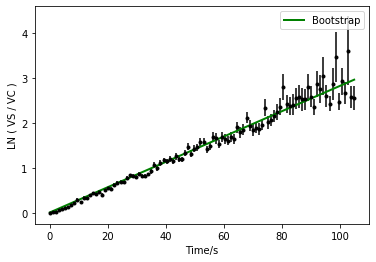

In [176]:
plt.errorbar(t , y , yerr=error_y , fmt='k.')
plt.xlabel("Time/s")
plt.ylabel("LN ( VS / VC )")

#plt.plot(t, func(t, LS_C), 'r', label = 'Least Square', linewidth=2.0)

plt.plot(t, func(t, BS_C), 'g', label = 'Bootstrap', linewidth=2.0)

#plt.plot(t, func(t, popt), 'y', label = 'Curvefit', linewidth=0.0)
plt.legend()
plt.show()

Function for equation before taking logs:

In [183]:
#Inputs: x data, capacitance
#Outputs: fitted y data
def func_2(x, C):
    return 0.242959 * np.exp (- x / (R * C) )

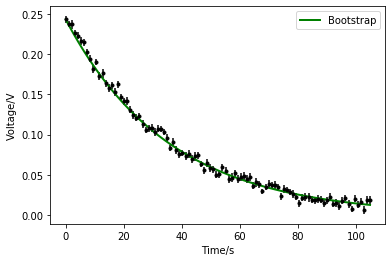

In [184]:
plt.errorbar(t , V , yerr=error_V , fmt='k.')
plt.xlabel("Time/s")
plt.ylabel("Voltage/V")

#plt.plot(t, func_2(t, LS_C), 'r', label = 'Least Square', linewidth=2.0)

plt.plot(t, func_2(t, BS_C), 'g', label = 'Bootstrap', linewidth=2.0)

#plt.plot(t, func_2(t, popt), 'y', label = 'Curvefit', linewidth=2.0)
plt.legend()
plt.show()

Plotting Residuals

<ErrorbarContainer object of 3 artists>

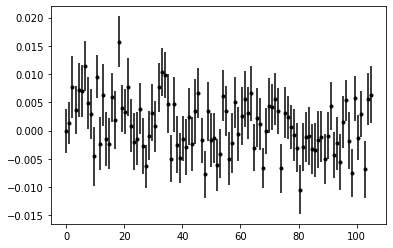

In [185]:
residual = V - func_2(t, BS_C)
plt.errorbar(t , residual , yerr=error_V , fmt='k.')

# Part 2: Analysis of a time series

Importing data:

In [4]:
system_1_data = ascii.read('RVdata_System_1__1.dat')
system_2_data = ascii.read('RVdata_System_2__1.dat')

print(system_1_data.colnames)

['t', 'RV', 'e_RV']


Assigning Data:

In [6]:
time_1 = system_1_data['t']
RV_1 = system_1_data['RV']
e_RV_1 = system_1_data['e_RV']

time_2 = np.asarray(system_2_data['t'])
RV_2 = system_2_data['RV']
e_RV_2 = system_2_data['e_RV']

# Dataset 1 

Plotting Data:

Text(0, 0.5, 'Radial Velocity/m/s')

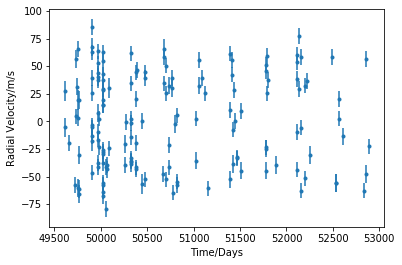

In [198]:
plt.errorbar(time_1, RV_1, yerr=e_RV_1, fmt='.')
plt.xlabel("Time/Days")
plt.ylabel("Radial Velocity/m/s")

Periodogram Function:

In [200]:
#Routine to calculate the Generalised Lomb Scargle (see Zechmeister & Kuster 2009).
#Inputs:
# t - time 
# y - data values
# sig - uncertainties on y
# period - array containing the periods on which the periodogram should be calculated.
#
#Outputs:
# p_om - the periodogram
# a_om - the amplitude of the cosine term 
# b_om - the amplitude of the sine term
# Note: total amplitude is sqrt(a_om+b_om)
def GLS(t,y,sig,period=np.logspace(-1.,1.4,int(1e5))):
    W=np.sum(1./sig**2)
    w=1./W * 1./sig**2

    Y=np.sum(w*y)
    YYh=np.sum(w*y*y)
    p_om=np.zeros(period.shape[0])
    a_om=np.zeros(period.shape[0])
    b_om=np.zeros(period.shape[0])
    for i,P in enumerate(period):
        omt=2.*np.pi*t/P
        cos_omt=np.cos(omt)
        sin_omt=np.sin(omt)
        C=np.sum(w*cos_omt)
        S=np.sum(w*sin_omt)
        YCh=np.sum(w*y*cos_omt)
        YSh=np.sum(w*y*sin_omt)
        CCh=np.sum(w*cos_omt*cos_omt)
        SSh=np.sum(w*sin_omt*sin_omt)
        CSh=np.sum(w*cos_omt*sin_omt)
        YY=YYh-Y*Y
        YC=YCh-Y*C
        YS=YSh-Y*S
        CC=CCh-C*C
        SS=SSh-S*S
        CS=CSh-C*S
        D=CC*SS-CS**2
        p_om[i]=(SS*YC**2+CC*YS**2-2*CS*YC*YS)/(YY*D)
        a_om[i]=(YC*SS-YS*CS)/D
        b_om[i]=(YS*CC-YC*CS)/D
    return p_om,a_om,b_om

Creating a Periodogram:

In [333]:
#Working out the maximum period from the max time measured/2
max_P_1 = np.log10((time_1[152] - time_1[0])/2.)

#Generating period times over log range between 0 and max P
P = np.logspace(0 , max_P_1 ,num=100000)

#Applying periodogram function
p_om, a_om, b_om = GLS ( time_1 , RV_1 , e_RV_1 , P )

Strongest signal at P=4.230636 days


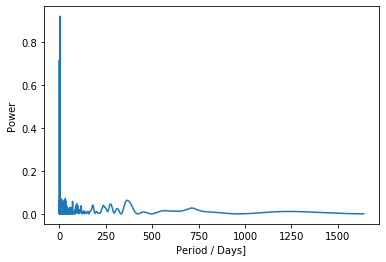

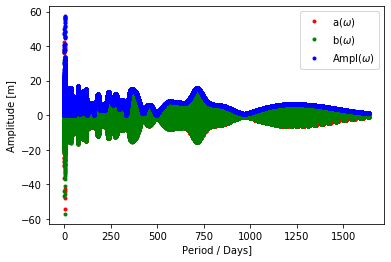

In [334]:
#Plot the power spectrum and amplitudes
plt.plot(P, p_om, '-')
plt.xlabel('Period / Days]')
plt.ylabel('Power')
plt.figure()

#Plotting individual Amplitudes
ampl = np.sqrt(a_om**2+b_om**2)
plt.plot(P, a_om ,'r.', label = 'a($\omega$)')
plt.plot( P, b_om, 'g.', label = 'b($\omega$)')
plt.plot( P, ampl,'b.', label = 'Ampl($\omega$)')
plt.xlabel('Period / Days]')
plt.ylabel('Amplitude [m]')
plt.legend()

#Find the strongest signal
high = np.argmax( p_om )
print('Strongest signal at P=%.6f days' % P[high])

Text(0, 0.5, 'Power')

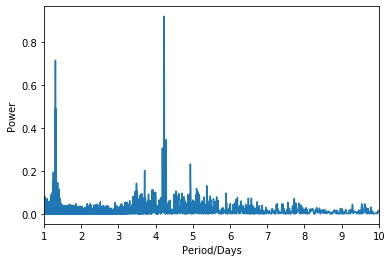

In [335]:
#Zooming in
plt.plot(P,p_om)
plt.xlim(1,10)
plt.xlabel('Period/Days')
plt.ylabel('Power')

Text(0, 0.5, 'Radial Velocity/MS-1')

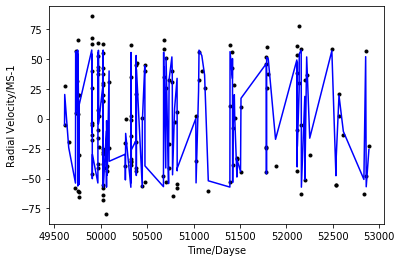

In [336]:
#Calculate model from strongest peak in the periodogram
model_1 = a_om[high] * np.cos ( 2. * np.pi * time_1 / P[high] ) + b_om [high] * np.sin ( 2. * np.pi * time_1 / P[high] )

#plot data with model over it
plt.figure()
plt.plot(time_1, RV_1, 'k.', label='data')
plt.plot(time_1, model_1, 'b-', label='model')
plt.legend
plt.xlabel('Time/Dayse')
plt.ylabel('Radial Velocity/MS-1')



Investigating White Noise for Periodograms:

Strongest signal at P=1.204 days


Text(0, 0.5, 'Radial Velocity')

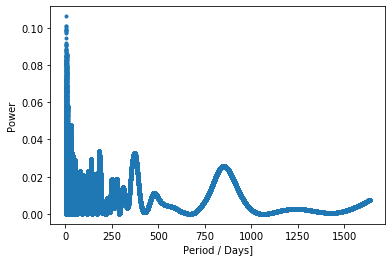

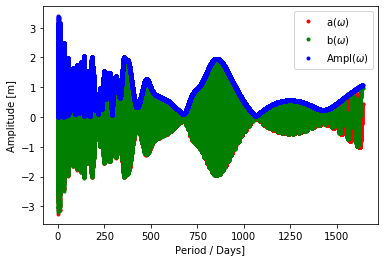

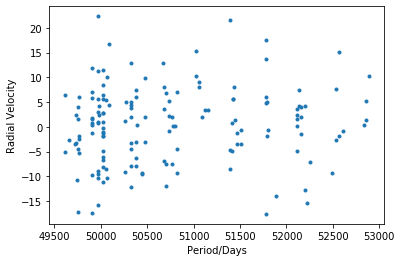

In [337]:
#Creating white noise
mockdata=np.random.normal(time_1*0.,e_RV_1)

#Creating Periodogram:
p_om_wn, a_om_wn, b_om_wn = GLS ( time_1 , mockdata , e_RV_1 , P )

#Plot the power spectrum and amplitudes
plt.plot(P, p_om_wn, '.')
plt.xlabel('Period / Days]')
plt.ylabel('Power')
plt.figure()

#Plotting individual Amplitudes
ampl = np.sqrt(a_om_wn**2+b_om_wn**2)
plt.plot(P, a_om_wn ,'r.', label = 'a($\omega$)')
plt.plot( P, b_om_wn, 'g.', label = 'b($\omega$)')
plt.plot( P, ampl,'b.', label = 'Ampl($\omega$)')
plt.xlabel('Period / Days]')
plt.ylabel('Amplitude [m]')
plt.legend()

#Find the strongest signal
high = np.argmax( p_om_wn )
print('Strongest signal at P=%.3f days' % P[high])

plt.figure()
plt.plot(time_1,mockdata,'.')
plt.xlabel('Period/Days')
plt.ylabel('Radial Velocity')

Text(0, 0.5, 'Power')

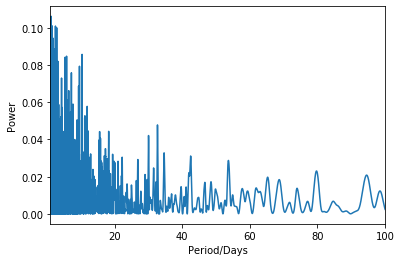

In [342]:
#Zooming in
plt.plot(P,p_om_wn)
plt.xlim(1,100)
plt.xlabel('Period/Days')
plt.ylabel('Power')

Model for RV:

In [329]:
#Inputs: x data, array containing parameters
#Outputs: Fitted y data

def RV_model(x, param):
    K = param[0]
    T = param[1]
    Phi = param[2]
    return K * np.sin ( 2 * np.pi * ( ( x / T ) + Phi ) )

Phase Folded Plot

Text(0, 0.5, 'Radial Velocity [ms-1]')

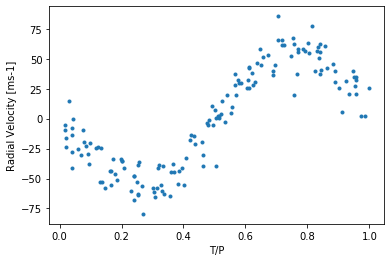

In [205]:
#calculating the phase folded data
phi_fold = (time_1/P[high])%1
plt.plot(phi_fold, RV_1,'.')
plt.xlabel('T/P')
plt.ylabel('Radial Velocity [ms-1]')

Grid Fitting For Chi Squared

In [311]:
#Creating arrays over range for each of the 3 parameters
K = np.arange(56.93, 56.96, 0.01)
Phi = np.arange(0.4,1., 0.001)
T = np.arange(4.2305, 4.2315, 0.000001)

#for looping:
i=0
j=0
k=0

#calculating sizes of arrays
size_K = len(K)
size_Phi = len(Phi)
size_T = len(T)

#creating an array of sizes depending on the above parameter arrays
chi_arr_1 = np.zeros(( size_K, size_Phi, size_T ))

#loop to calculate best fit model, and assign chi squared value to array corresponding to each of the K, Phi & T values 
#in above array  
for i,K_1 in enumerate(K):
    for j,Phi_1 in enumerate(Phi):
        for k,T_1 in enumerate(T):
          
            fit_RV_1 = K_1 * np.sin ( 2 * np.pi * ( ( time_1 / T_1 ) + Phi_1 ) )
            chi_arr_1[i,j,k]= np.sum( ( RV_1 - fit_RV_1 )**2 / (e_RV_1)**2 )
  
#finding minimum indices            
chi_values = np.argwhere(chi_arr_1 == np.min(chi_arr_1))
                      
#Getting each of the values:                      
k_index = chi_values[0][0]
phi_index = chi_values[0][1]
t_index = chi_values[0][2]

In [312]:
print(k_index, phi_index, t_index)
print(K[k_index], Phi[phi_index],T[t_index])
print(np.amin(chi_arr_1))
print(np.amin(chi_arr_1)/len(time_1))

3 482 274
56.959999999999994 0.8820000000000005 4.2307740000000384
407.1841290395393
2.661334176729015


MCMC Function:

In [206]:
#mcmc:  function to perform a simple MCMC using the Metropolis-Hastings Algorithm

#Inputs:
#func  - the function to be used for fitting. Function should accept 2 inputs
 #       the first is the x-values at which the model is calculated, the second
  #      is a numpy array for the parameters.
#x     - the x-values at which the model should be calculated (numpy array)
#y     - the value of the data for each x (numpy array)
#sig   - the uncertainty on y (numpy array)
#pars0 - The initial paramters from which to start the MCMC chain (numpy array)
#stepsize - the stepsize for each of the parameters (numpy array)
#nstep    - the number of steps in the MCMC chain

#Outputs:
#chain    - The MCMC chain as a (Nsteps, Npars) numpy array


def MCMC(func , x , y , sig , pars0 , stepsize , nstep=1e4 ):
    
    nstep = int ( nstep )
    npars = pars0.shape [ 0 ]
    chain = np.zeros ( ( int ( nstep ) , npars ) )
    chi2 = np.zeros( int( nstep ) )

    chain[ 0 , : ] = pars0.copy()
    mdl = func( x , pars0 )
    chi2 [ 0 ] = np.sum( ( y - mdl ) ** 2 / sig ** 2 )
    njump = 0
    
    for i in range( 1 , nstep ):
        pars_new = np.random.normal ( chain [ i - 1 , : ] , stepsize )
        mdl = func ( x , pars_new )
        chi2_new = np.sum ( ( y - mdl ) ** 2 / sig ** 2 )
        if (chi2_new > chi2[i-1]):
            p0=np.exp(-(chi2_new-chi2[i-1])/2.)
            p=np.random.uniform(0,1,1)
            if  p<=p0:
                chain[i,:]=pars_new
                chi2[i]=chi2_new
                njump=njump+1
            else:
                chain[i,:]=chain[i-1,:]
                chi2[i]=chi2[i-1]
        else:
            chain[i,:]=pars_new
            njump=njump+1
            chi2[i]=chi2_new
            
    print('Jump fraction: %.6f' %(njump/nstep))
    return chain


MCMC Fitting:

In [291]:
#Assigning the starting values for each of the parameters
params=np.asarray([57.2,  4.23065, 0.88])
#Assigning step size
steps=np.asarray([0.05,0.000001, 0.01])
#applying mcmc function
mcmc = MCMC(RV_model , time_1 , RV_1 , e_RV_1 , params, steps, nstep=1e6)

Jump fraction: 0.261640


Working with Period:

Average time period =
4.230790586979367
Standard Deviation =
4.0326280007037244e-05

Median time period = 4.23079
Lower error = 3.86917e-05, Higher Error = 4.61327e-05


Text(0, 0.5, 'Frequency')

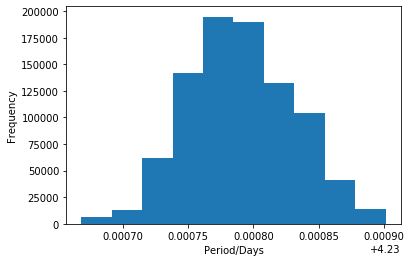

In [292]:
#getting data from mcmc chain array
k_1 = mcmc[:,0]
t_1 = mcmc[:,1]
phi_1 = mcmc[:,2]

#getting 10% of the way through array
size_t_1 = len(t_1)
percent_10 = int(size_t_1/10)

#cutting out first 10 percent:
new_t_1 =  t_1[percent_10:]

#working out 16-84% error:
l_error, h_error, t_median = error(new_t_1)

print('Average time period =')
print(np.average(new_t_1))
print('Standard Deviation =' )
print(np.std(new_t_1))

print('\nMedian time period = %g'%(t_median))
print('Lower error = %g, Higher Error = %g' %(l_error,h_error) )

#plotting histogram
plt.hist(new_t_1, bins=10)
plt.xlabel('Period/Days')
plt.ylabel('Frequency')

Working with amplitude

Average amplitude =
57.3064506263842
Standard Deviation =
0.8838559312257406

Median amplitude = 57.2782
Lower error = 0.878668, Higher Error = 0.906818


Text(0, 0.5, 'Frequency')

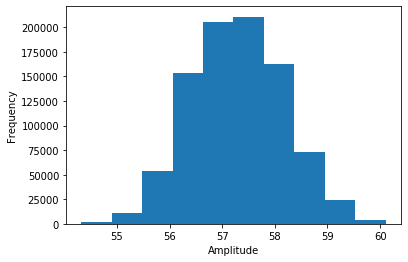

In [293]:
#cutting out first 10 percent:
new_k_1 =  k_1[percent_10:]

#working out 16-84% error:
l_error, h_error, k_median = error(new_k_1)


print('Average amplitude =')
print(np.average(k_1))
print('Standard Deviation =' )
print(np.std(k_1))

print('\nMedian amplitude = %g'%(k_median))
print('Lower error = %g, Higher Error = %g' %(l_error,h_error) )

plt.hist(new_k_1, bins=10)
plt.xlabel('Amplitude')
plt.ylabel('Frequency')


Working with phase difference

Average phase shift =
0.9277661784919498
Standard Deviation =
0.11599714295350744

Median phi =0.922992
Lower error = 0.109651, Higher Error = 0.13084


Text(0, 0.5, 'Frequency')

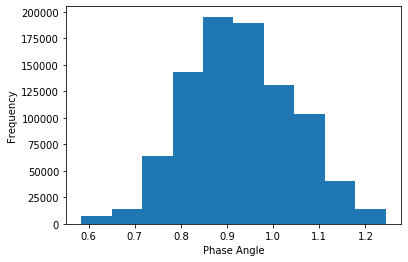

In [294]:

#cutting out first 10 percent:
new_phi_1 =  phi_1[percent_10:]

#working out 16-84% error:
l_error, h_error, phi_median = error(new_phi_1)


print('Average phase shift =')
print(np.average(phi_1))
print('Standard Deviation =' )
print(np.std(phi_1))


print('\nMedian phi =%g'%(phi_median))
print('Lower error = %g, Higher Error = %g' %(l_error,h_error) )

plt.hist(new_phi_1,bins=10)
plt.xlabel('Phase Angle')
plt.ylabel('Frequency')


In [429]:
#Getting data within an array
params = [k_median, t_median, phi_median]
print(params)

[57.27816595141721, 4.230788468199277, 0.922991831530687]


Over Plotting Model:

Text(0, 0.5, 'Radial Velocity/ms-1')

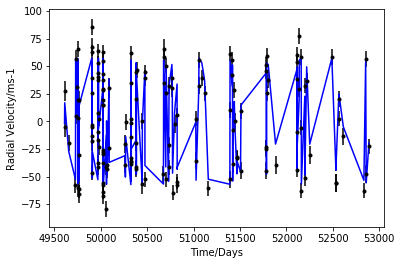

In [353]:
#plot data with model over it
plt.figure()
plt.errorbar(time_1, RV_1, yerr=e_RV_1, fmt='k.')
plt.plot(time_1, RV_model(time_1, params), 'b-', label='model')
plt.legend
plt.xlabel('Time/Days')
plt.ylabel('Radial Velocity/ms-1')

Removing peak:

Strongest signal at P=359.185 days


Text(0, 0.5, 'Residuals')

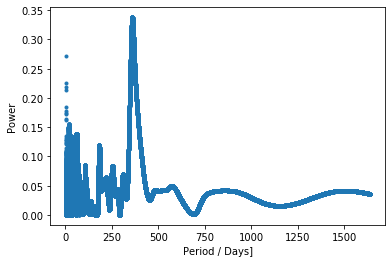

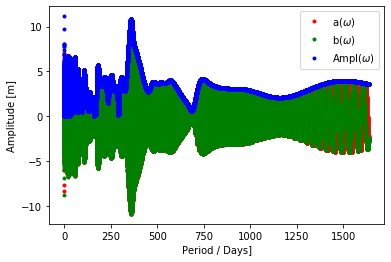

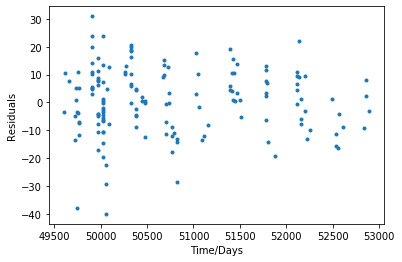

In [462]:
#Calculating Residuals
residual_1 = RV_1 - RV_model(time_1, params)

#Periodogram of Residuals
p_om_te, a_om_te, b_om_te = GLS ( time_1 , residual_1 , e_RV_1 , P )

#Plot the power spectrum and amplitudes
plt.plot(P, p_om_te, '.')
plt.xlabel('Period / Days]')
plt.ylabel('Power')
plt.figure()

#Plotting individual Amplitudes
ampl = np.sqrt(a_om_te**2+b_om_te**2)
plt.plot(P, a_om_te ,'r.', label = 'a($\omega$)')
plt.plot( P, b_om_te, 'g.', label = 'b($\omega$)')
plt.plot( P, ampl,'b.', label = 'Ampl($\omega$)')
plt.xlabel('Period / Days]')
plt.ylabel('Amplitude [m]')
plt.legend()

#Find the strongest signal
high = np.argmax( p_om_te )
print('Strongest signal at P=%.3f days' % P[high])

plt.figure()
plt.plot(time_1,residual_1,'.')
plt.xlabel('Time/Days')
plt.ylabel('Residuals')


Text(0, 0.5, 'Power')

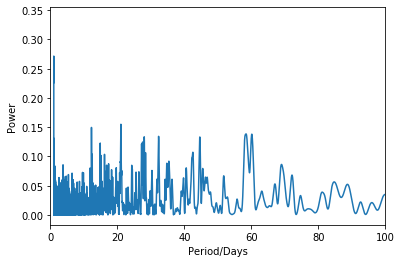

In [463]:
#Zooming in
plt.plot(P,p_om_te)
plt.xlim(0,100)
plt.xlabel('Period/Days')
plt.ylabel('Power')

Redefining Function to put into Curvefit:

In [14]:
#inputs: x data, each of the individual parameters
#output: fitted y data
def RV_model_2(x, K, T, Phi):    
    return K * np.sin ( 2 * np.pi * ( ( x / T ) + Phi ) )

Using Curvefit:

In [297]:
#initial guess
p0_1 = params
popt, pcov = curve_fit(RV_model_2, time_1, RV_1, bounds=([50,4,0.], [60., 4.3, 1.]), p0=p0_1)
print(popt)

[56.97078965  4.23077941  0.89709405]


Calculating chi squared:

In [298]:
red_chi_val_1= np.sum( ( RV_1 - RV_model(time_1, params) )**2 / (e_RV_1)**2 ) / len(time_1)
print(red_chi_val_1)

2.661235429335602


# Dataset 2

Plotting Data:

Text(0, 0.5, 'Radial Velocity/m/s')

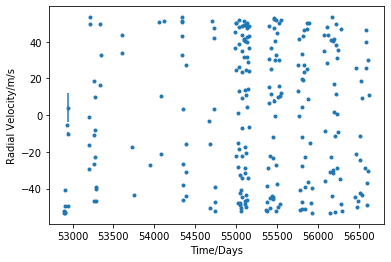

In [9]:
plt.errorbar(time_2, RV_2, yerr=e_RV_2, fmt='.')
plt.xlabel("Time/Days")
plt.ylabel("Radial Velocity/m/s")

Creating Periodogram:

In [447]:
#generating the period values with same method as above:
max_P_2 = np.log10((time_2[152] - time_2[0])/2.)
P_2 = np.logspace(0 , max_P_2 ,num=100000)

p_om, a_om, b_om = GLS ( time_2 , RV_2 , e_RV_2 , P_2 )

Strongest signal at P=20.43019921 days


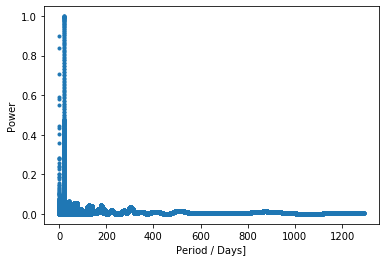

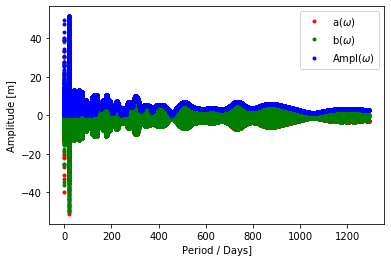

In [448]:
#Plot the power spectrum and amplitudes
plt.plot(P_2, p_om, '.')
plt.xlabel('Period / Days]')
plt.ylabel('Power')
plt.figure()

ampl = np.sqrt(a_om**2+b_om**2)
plt.plot(P_2, a_om ,'r.', label = 'a($\omega$)')
plt.plot( P_2, b_om, 'g.', label = 'b($\omega$)')
plt.plot( P_2, ampl,'b.', label = 'Ampl($\omega$)')
plt.xlabel('Period / Days]')
plt.ylabel('Amplitude [m]')
plt.legend()

#Find the strongest signal
idx=np.argmax(p_om)
print('Strongest signal at P=%.8f days' % P_2[idx])

Text(0, 0.5, 'Power')

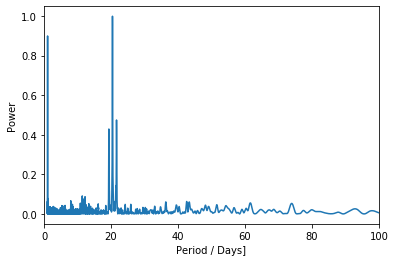

In [449]:
plt.plot(P_2,p_om)
plt.xlim(0,100)
plt.xlabel('Period / Days]')
plt.ylabel('Power')

Investigating White Noise

Strongest signal at P=1.64369092 days


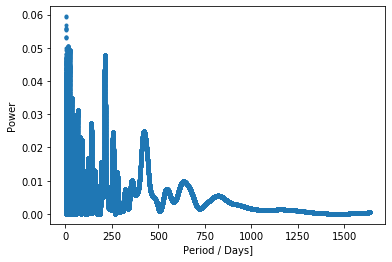

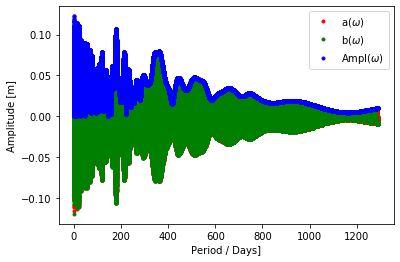

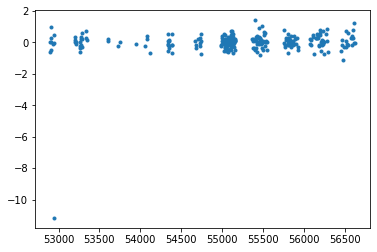

In [450]:
#Creating white noise
mockdata=np.random.normal(time_2*0.,e_RV_2)

p_om_wn, a_om_wn, b_om_wn = GLS ( time_2 , mockdata , e_RV_2 , P_2 )

#Plot the power spectrum and amplitudes
plt.plot(P, p_om_wn, '.')
plt.xlabel('Period / Days]')
plt.ylabel('Power')
plt.figure()

ampl = np.sqrt(a_om_wn**2+b_om_wn**2)
plt.plot(P_2, a_om_wn ,'r.', label = 'a($\omega$)')
plt.plot( P_2, b_om_wn, 'g.', label = 'b($\omega$)')
plt.plot( P_2, ampl,'b.', label = 'Ampl($\omega$)')
plt.xlabel('Period / Days]')
plt.ylabel('Amplitude [m]')
plt.legend()

#Find the strongest signal
high_wn = np.argmax( p_om_wn )
print('Strongest signal at P=%.8f days' % P[high_wn])

plt.figure()
plt.plot(time_2,mockdata,'.')

Text(0, 0.5, 'Power')

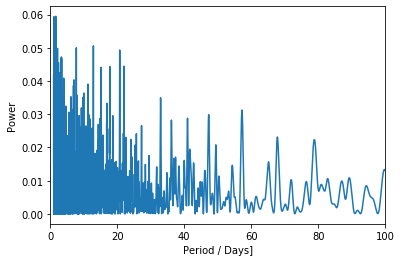

In [451]:
plt.plot(P_2,p_om_wn)
plt.xlim(0,100)
plt.xlabel('Period / Days]')
plt.ylabel('Power')

RV Folded Curve:

53.5774


Text(0, 0.5, 'Radial Velocity [ms-1]')

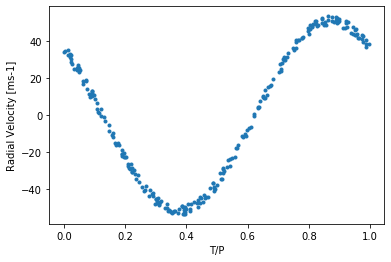

In [301]:
#Creating folded data:
phi_fold_2 = (time_2/P_2[idx])%1
plt.plot(phi_fold_2, RV_2,'.')
print(np.amax(RV_2))
plt.xlabel('T/P')
plt.ylabel('Radial Velocity [ms-1]')

Chi squared fitting:

In [409]:
#importing product tool:
from itertools import product

#Creating arrays over range for each of the 3 parameters  
K = np.arange(51.4,51.6, 0.01)
Phi = np.arange(0.344,0.345, 0.0001)
T = np.arange(20.42993, 20.42998, 0.00001)

#calculating sizes of arrays
size_K = len(K)
size_Phi = len(Phi)
size_T = len(T)

#creating an array of sizes depending on the above parameter arrays
chi_arr_1 = np.zeros(( size_K, size_Phi, size_T ))

#loop to calculate best fit model, and assign chi squared value to array corresponding to each of the K, Phi & T values 
#in above array B
for (i,K_1), (j,Phi_1), (k,T_1) in product(enumerate(K),enumerate(Phi),enumerate(T)):
            fit_RV_1 = K_1 * np.sin ( 2 * np.pi * ( ( time_2 / T_1 ) + Phi_1 ) )
            chi_arr_1[i,j,k]= np.sum( ( RV_2 - fit_RV_1 )**2 / (e_RV_2)**2 )

#finding minimum indices             
chi_values = np.argwhere(chi_arr_1 == np.min(chi_arr_1))
 
#Getting each of the values:                      
k_index = chi_values[0][0]
phi_index = chi_values[0][1]
t_index = chi_values[0][2]

In [410]:
print(k_index, phi_index, t_index)
print(K[k_index], Phi[phi_index],T[t_index])
print(np.amin(chi_arr_1))
print(np.amin(chi_arr_1)/len(time_2))

5 9 3
51.44999999999999 0.3448999999999999 20.429959999999998
4147.688648425669
16.4590819381971
[51.45133587289335, 20.429956564793212, 0.3444776810893924]


Removing this data peak:

In [441]:
test_y = [51.451, 24.429956, 0.34448]
residual_2 = RV_2 - RV_model(time_2, test_y)

Creating a new Periodogram with this data:

In [442]:
p_om, a_om, b_om = GLS ( time_2 , residual_2 , e_RV_2 , P_2 )

Plotting:

Strongest signal at P=20.43166280 days


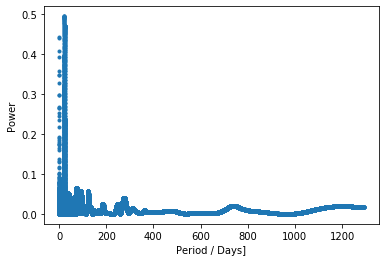

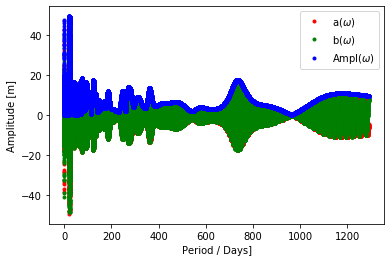

In [443]:
#Plot the power spectrum and amplitudes
plt.plot(P_2, p_om, '.')
plt.xlabel('Period / Days]')
plt.ylabel('Power')
plt.figure()

ampl = np.sqrt(a_om**2+b_om**2)
plt.plot(P_2, a_om ,'r.', label = 'a($\omega$)')
plt.plot( P_2, b_om, 'g.', label = 'b($\omega$)')
plt.plot( P_2, ampl,'b.', label = 'Ampl($\omega$)')
plt.xlabel('Period / Days]')
plt.ylabel('Amplitude [m]')
plt.legend()

#Find the strongest signal
idx=np.argmax(p_om)
print('Strongest signal at P=%.8f days' % P_2[idx])

Text(0, 0.5, 'Power')

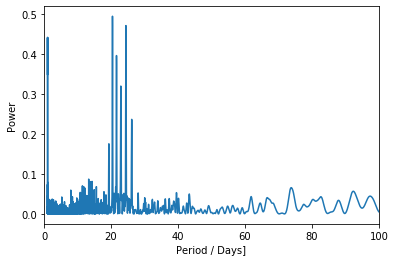

In [444]:
plt.plot(P_2,p_om)
plt.xlim(0,100)
plt.xlabel('Period / Days]')
plt.ylabel('Power')

MCMC for dataset 2:

In [358]:
#Assigning the starting values for each of the parameters
params=np.asarray([50.2,  20.42992, 0.35])
#Assigning step size
steps=np.asarray([0.05,0.000001, 0.001])
#applying mcmc function
mcmc = MCMC(RV_model , time_2 , RV_2 , e_RV_2 , params, steps, nstep=1e6)

Jump fraction: 0.092163


Working with period:

Average time period =
20.42995324422602
Standard Deviation =
5.176900651707333e-05

Median time period = 20.43
Lower error = 4.95178e-05, Higher Error = 3.60604e-05


Text(0, 0.5, 'Frequency')

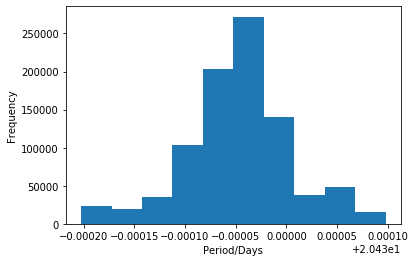

In [438]:
#getting data from mcmc chain array
k_2 = mcmc[:,0]
phi_2 = mcmc[:,2]
t_2 = mcmc[:,1]

#getting 10% of the way through array
size_t_2 = len(t_2)
percent_10 = int(size_t_2/10)

#cutting out first 10 percent:
new_t_2 =  t_2[percent_10:]

#working out 16-84% error:
l_error, h_error, t_2median = error(new_t_2)

print('Average time period =')
print(np.average(new_t_2))
print('Standard Deviation =' )
print(np.std(new_t_2))

print('\nMedian time period = %g'%(t_2median))
print('Lower error = %g, Higher Error = %g' %(l_error,h_error) )

#plotting histogram
plt.hist(new_t_2, bins=10)
plt.xlabel('Period/Days')
plt.ylabel('Frequency')

Working with Amplitude:

Average amplitude =
51.451279528778024
Standard Deviation =
0.03327755769582516

Median amplitude = 51.4513
Lower error = 0.0331108, Higher Error = 0.0329442


Text(0, 0.5, 'Frequency')

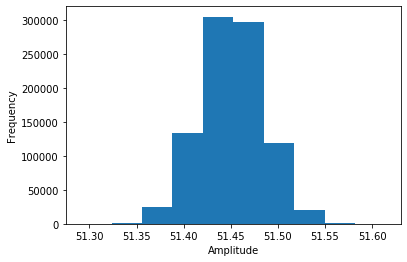

In [439]:
#cutting out first 10 percent:
new_k_2 =  k_2[percent_10:]

#working out 16-84% error:
l_error, h_error, k_2median = error(new_k_2)


print('Average amplitude =')
print(np.average(new_k_2))
print('Standard Deviation =' )
print(np.std(new_k_2))

print('\nMedian amplitude = %g'%(k_2median))
print('Lower error = %g, Higher Error = %g' %(l_error,h_error) )

plt.hist(new_k_2, bins=10)
plt.xlabel('Amplitude')
plt.ylabel('Frequency')


Working with Phase Angle

Average amplitude =
0.34403778962203735
Standard Deviation =
0.006832775246329049

Median amplitude = 0.344478
Lower error = 0.00653432, Higher Error = 0.00475022


Text(0, 0.5, 'Frequency')

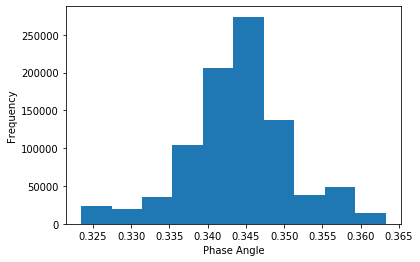

In [440]:
#cutting out first 10 percent:
new_phi_2 =  phi_2[percent_10:]

#working out 16-84% error:
l_error, h_error, phi_2median = error(new_phi_2)


print('Average amplitude =')
print(np.average(new_phi_2))
print('Standard Deviation =' )
print(np.std(new_phi_2))

print('\nMedian amplitude = %g'%(phi_2median))
print('Lower error = %g, Higher Error = %g' %(l_error,h_error) )

plt.hist(new_phi_2, bins=10)
plt.xlabel('Phase Angle')
plt.ylabel('Frequency')


In [368]:
#Putting the parameters into an array
params_2 = [k_2median, t_2median, phi_2median]
print(params_2)

[51.45133587289335, 20.429956564793212, 0.3444776810893924]


Fitting it with Curvefit:

In [369]:
#initial guess
p0_2 = params_2

popt, pcov = curve_fit(RV_model_2, time_2, RV_2, bounds=(0, [100., 500., 1.]), p0=p0_2)
print(popt)

[51.49520383 20.42996171  0.34517859]


Over plotting with data:

Text(0, 0.5, 'Radial Velocity/ms-1')

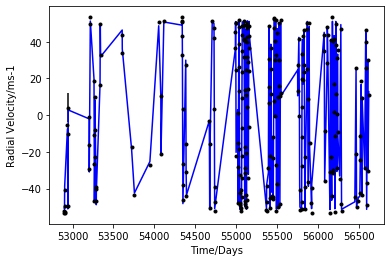

In [460]:
#plot data with model over it
plt.figure()
plt.errorbar(time_2, RV_2,yerr=e_RV_2,  fmt='k.')
plt.plot(time_2, RV_model(time_2, params_2), 'b-')
plt.xlabel('Time/Days')
plt.ylabel('Radial Velocity/ms-1')

Calculating Reduced Chi Squared:

In [431]:
red_chi_val_2= np.sum( ( RV_2 - RV_model(time_2, params_2) )**2 / (e_RV_2)**2 ) / len(time_2)
print(red_chi_val_2)

16.458915733763302


Plotting Residuals:

Text(0.5, 0, 'Time/Days')

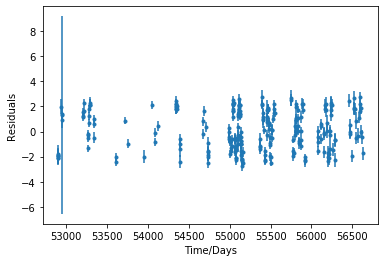

In [461]:
residual_3 = RV_2 -  RV_model(time_2, params_2)
plt.errorbar(time_2, residual_3, yerr=e_RV_2, fmt='.')
plt.ylabel('Residuals')
plt.xlabel('Time/Days')

Eoghan White
40197617